# Quora question pairs: training

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, dot, Dense, Lambda, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Initialize global variables

In [2]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights_network2.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

## Load the dataset, embedding matrix and word count

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [27]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [5]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

#layer 1 for question 1 to convert the sequence of vectors into dense representation
q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
#We use time distributed layer to formulate the sequential nature of our words in the question
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

#layer 1 for question 2 to convert the sequence of vectors into dense representation
q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
#We use time distributed layer to formulate the sequential nature of our words in the question
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

#Concatenate the representations for question 1 and 2
merged = concatenate([q1,q2])

#dense layer 1
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 5
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 6
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)


#final prediction using sigmoid activation
is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      28947900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 300)      28947900    input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

## Train the model, checkpointing weights with best validation accuracy

In [9]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()

#callback to store the best weights
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-03-25 20:48:08.024630
Train on 327472 samples, validate on 36386 samples
Epoch 1/25
 - 211s - loss: 0.5480 - acc: 0.7215 - val_loss: 0.4958 - val_acc: 0.7497
Epoch 2/25
 - 232s - loss: 0.4929 - acc: 0.7571 - val_loss: 0.4773 - val_acc: 0.7614
Epoch 3/25
 - 245s - loss: 0.4672 - acc: 0.7739 - val_loss: 0.4624 - val_acc: 0.7715
Epoch 4/25
 - 251s - loss: 0.4448 - acc: 0.7880 - val_loss: 0.4568 - val_acc: 0.7747
Epoch 5/25
 - 254s - loss: 0.4271 - acc: 0.7997 - val_loss: 0.4381 - val_acc: 0.7865
Epoch 6/25
 - 306s - loss: 0.4092 - acc: 0.8105 - val_loss: 0.4618 - val_acc: 0.7672
Epoch 7/25
 - 330s - loss: 0.3961 - acc: 0.8195 - val_loss: 0.4251 - val_acc: 0.7948
Epoch 8/25
 - 332s - loss: 0.3837 - acc: 0.8261 - val_loss: 0.4200 - val_acc: 0.7976
Epoch 9/25
 - 331s - loss: 0.3734 - acc: 0.8324 - val_loss: 0.4205 - val_acc: 0.8001
Epoch 10/25
 - 328s - loss: 0.3628 - acc: 0.8372 - val_loss: 0.4152 - val_acc: 0.8023
Epoch 11/25
 - 329s - loss: 0.3539 - acc: 0.8435 -

## Plot training and validation accuracy

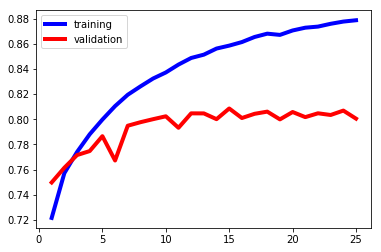

In [10]:
import matplotlib.pyplot as plt
# Data
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']}) 
# multiple line plot
ax= plt.plot( 'epoch', 'training', data=acc,markersize=12, color='blue', linewidth=4)
ax= plt.plot( 'epoch', 'validation', data=acc,markersize=12, color='red', linewidth=4)

plt.legend()

## Print best validation accuracy and epoch

In [12]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 15 = 0.8086


## Evaluate the model with best validation accuracy on the test partition

In [7]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4094, accuracy = 0.8091


# Testing individual sentences

### Use this section as a server for the Web Application

In [7]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import json
from keras.models import Model
from keras.layers import Input, TimeDistributed, dot, Dense, Lambda, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

In [8]:
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights_network2.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']
    
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))

with open('word_index.pickle', 'rb') as handle:
    word_indices = pickle.load(handle)

In [9]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

#layer 1 for question 1 to convert the sequence of vectors into dense representation
q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
#We use time distributed layer to formulate the sequential nature of our words in the question
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

#layer 1 for question 2 to convert the sequence of vectors into dense representation
q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
#We use time distributed layer to formulate the sequential nature of our words in the question
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

#Concatenate the representations for question 1 and 2
merged = concatenate([q1,q2])

#dense layer 1
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 5
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 6
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)


#final prediction using sigmoid activation
is_duplicate = Dense(1, activation='sigmoid')(merged)
print(is_duplicate)
model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Tensor("dense_9/Sigmoid:0", shape=(?, 1), dtype=float32)


In [17]:
w = 'bagus'
word_indices[w] for w in 

{'hankook': 74910, 'blight': 49859, 'tharoor': 20397, 'postgres': 53516, 'carbocation': 85041, 'gurdy': 67289, 'savoy': 67386, 'pasco': 63199, 'getwp': 83515, 'chanakya': 11025, 'ivysaur': 56957, "deepika's": 60143, 'vinod': 30551, '意思意思': 32779, 'barbaresco': 48356, 'throughout': 3692, 'musica': 37101, 'keypoint': 34194, 'electroplate': 63360, 'circus': 17002, 'booming': 22860, 'just12': 62018, 'aluminium': 7581, 'lacking': 10623, 'coupel': 66758, "red's": 42221, 'tasted': 16435, 'contract': 3517, 'saxophone': 19882, 'rottweiler': 7178, 'lieder': 52920, 'y50': 29256, 'agrabati': 64644, 'aboutwhy': 95831, 'francisco': 1704, 'monetary': 6062, 'traction': 7692, 'costly…': 93919, 'outclass': 92915, 'mapbox': 90867, 'reuters': 14873, 'document”': 49913, 'chandraguptas': 83445, 'dhaka': 16837, 'violets': 85920, 'boyfriend’s': 26167, 'radians': 27352, 'shinedown’s': 31882, 'critian': 67541, '2002': 4364, "'network'": 93168, 'infects': 80572, 'iilm': 33605, 'osteoporosis': 40866, 'pippli': 60

In [10]:
def word2vec(question):
    word_seq = keras.preprocessing.text.text_to_word_sequence(question)
    
    vec_sequence = [word_indices[w] for w in word_seq]
    
    vec_sequence = pad_sequences([vec_sequence], maxlen= 25)
    return vec_sequence
 

#### Input questions

In [18]:
question1 = 'Hi Im here waiting for you.where are you?'
question2 = 'Hi what era is this?'

model.load_weights(MODEL_WEIGHTS_FILE)
predictions = model.predict([word2vec(question1), word2vec(question2)], verbose=0)



In [19]:
predictions

array([[0.0143868]], dtype=float32)